In [ ]:
!pip install prometheus-api prometheus_api_client google-cloud-bigquery google-cloud-bigquery-storage db-dtypes

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 26.9 MB/s eta 0:00:00
  Created wheel for prometheus-api: filename=prometheus_api-0.0.1-py3-none-any.whl size=2469 sha256=1b6c1e4dbed19b9b2146fe1e9928a181397390f813aa8cd7e190494c0eaef637
  Stored in directory: /root/.cache/pip/wheels/6e/a0/29/69eb6dd086b9e62de9b06e5812175b4dc4e7c028a86d9ab09b
Successfully built prometheus-api


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import altair as alt
from google.cloud import bigquery
from google.cloud import bigquery_storage
import matplotlib.pyplot as plt, os, random
from scipy import stats
import prometheus_api_client
import tensorflow as tf


# Provide credentials to the runtime
from google.colab import auth
from google.cloud.bigquery import magics

auth.authenticate_user()
print('Authenticated')
project_id = 'poc-marvel'
# Set the default project id for %bigquery magic
magics.context.project = project_id

# Use the client to run queries constructed from a more complicated function.
client = bigquery.Client(project=project_id)
bqstorage_client = bigquery_storage.BigQueryReadClient()
CELL = 'c'

Authenticated


✓ gct_clean.pkl salvo


<ipython-input-4-ba6eb0fdcf19>:79: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  gaps   = prom_raw.index.to_series().diff().gt("2H")


Prometheus – bloco #0: 2021-02-02 05:00:04.720999936+00:00 → 2021-02-09 04:59:54.709000192+00:00 (60480 samples)
✓ prom_clean_7d.pkl salvo   (336 pontos)
✓ scale_params.json atualizado


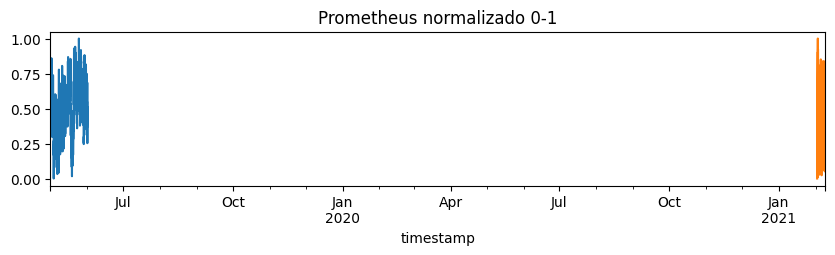

In [ ]:
# ============================================================================
# (Prometheus + Google Cluster Trace 2019‑C)
# ============================================================================

import os, json, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy import stats
from google.colab import auth
from google.cloud import bigquery, bigquery_storage

# --------------------------------------------------------------
DATA_DIR = "../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/"
os.makedirs(DATA_DIR, exist_ok=True)
PROJECT_ID = "poc-marvel"
CELL       = "c"            # Borg cell
auth.authenticate_user()

# -----------------------------------------------
def clean_series(series, freq="30min"):
    """Retorna série normalizada 0‑1 e dicionário {log_min, log_max}"""
    s = series.resample(freq).mean()
    s = s.interpolate("spline", order=3)
    z = np.abs(stats.zscore(s, nan_policy="omit"))
    s[z > 3] = np.nan
    s = s.interpolate("spline", order=3)

    log_s  = np.log1p(s)
    log_min, log_max = log_s.min(), log_s.max()
    s_norm = (log_s - log_min) / (log_max - log_min)
    return s_norm, {"log_min": float(log_min), "log_max": float(log_max)}

# --------------------------------------------------
client = bigquery.Client(project=PROJECT_ID)
bqstor = bigquery_storage.BigQueryReadClient()


qry_cap = f"""
SELECT SUM(memory_cap) AS mem_cap
FROM (
  SELECT machine_id, MAX(capacity.memory) AS memory_cap
  FROM `google.com:google-cluster-data`.clusterdata_2019_{CELL}.machine_events
  GROUP BY machine_id )
"""
cell_cap = client.query(qry_cap).result().to_dataframe()["mem_cap"][0]

#30 min
qry_ts = f"""
WITH per_instance AS (
  SELECT start_time AS t, average_usage.memory AS m
  FROM `google.com:google-cluster-data`.clusterdata_2019_{CELL}.instance_usage
  WHERE (alloc_collection_id IS NULL OR alloc_collection_id = 0)
    AND (end_time - start_time) >= (5 * 60 * 1e6)
),
per_30 AS (
  SELECT CAST(FLOOR(t/(1e6*60*30)) AS INT64) AS slot,
         SUM(m)/(6*{cell_cap})                 AS mem_norm
  FROM per_instance GROUP BY slot )
SELECT slot, mem_norm FROM per_30 ORDER BY slot
"""
df = client.query(qry_ts).result().to_dataframe(bqstorage_client=bqstor)
origin = pd.Timestamp("2019-05-01", tz="UTC")
df["timestamp"] = origin + pd.to_timedelta(df.slot*30, unit="min")
gct_raw = df.set_index("timestamp")["mem_norm"].asfreq("30min")

gct_clean, gct_scale = clean_series(gct_raw)
gct_clean.to_pickle(os.path.join(DATA_DIR, "gct_clean.pkl"))
print("✓ gct_clean.pkl salvo")

#7 days
prom_raw = pd.read_pickle(os.path.join(DATA_DIR, "ts.pkl"))

#DateTimeIndex + num
if not isinstance(prom_raw.index, pd.DatetimeIndex):
    prom_raw.index = pd.to_datetime(prom_raw.index, unit="s")
prom_raw["value"] = pd.to_numeric(prom_raw["value"], errors="coerce")
prom_raw = prom_raw.sort_index()

gaps   = prom_raw.index.to_series().diff().gt("2H")
blocks = gaps.cumsum()
first_block = blocks.eq(0)
prom_block  = prom_raw.loc[first_block, "value"]

print("Prometheus – bloco #0:",
      prom_block.index.min(), "→", prom_block.index.max(),
      f"({len(prom_block)} samples)")

prom_clean, prom_scale = clean_series(prom_block)
prom_path = os.path.join(DATA_DIR, "prom_clean_7d.pkl")
prom_clean.to_pickle(prom_path)
print(f"✓ prom_clean_7d.pkl salvo   ({len(prom_clean)} pontos)")

scale_file = os.path.join(DATA_DIR, "scale_params.json")
with open(scale_file) as fp:
    scale_dict = json.load(fp)

scale_dict["Prometheus"] = prom_scale

with open(scale_file, "w") as fp:
    json.dump(scale_dict, fp, indent=2)
print("✓ scale_params.json atualizado")


for name, s in [("GCT", gct_clean), ("Prometheus", prom_clean)]:
    s.plot(figsize=(10,2), title=f"{name} normalizado 0‑1")
plt.show()


In [ ]:
from threading import local
# ============================================================================
# Baseline LSTM  — Google Cluster Trace 2019‑C
# ============================================================================

import os, json, time, numpy as np, pandas as pd, tensorflow as tf, pickle
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# ---------- GPU -----------------------------------------------------------------
import tensorflow as tf
import os


gpus = tf.config.list_physical_devices('GPU')
if gpus:
  print(f"✅ GPU detectada: {[gpu.name for gpu in gpus]}")
  tf.keras.mixed_precision.set_global_policy("mixed_float16")
  strategy = tf.distribute.MirroredStrategy()
  print(f"Estratégia de distribuição: {strategy}")

#import tensorflow as tf
#
#try:
#    # Inicialização da TPU
#    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
#    tf.config.experimental_connect_to_cluster(resolver)
#    tf.tpu.experimental.initialize_tpu_system(resolver)
#   strategy = tf.distribute.TPUStrategy(resolver)
#    print("✅ TPU inicializada com sucesso!")
#except ValueError:
#    print("⚠️ TPU não detectada. Verifique se o runtime está configurado para TPU.")



# ---------- paths & seeds --------------------------------------------------------
DATA_DIR   = "../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/"
METRIC_DIR = os.path.join(DATA_DIR, "metrics"); os.makedirs(METRIC_DIR, exist_ok=True)
SEEDS = range(42, 62)          # 20 execuções

# ---------- Google Trace -----------------------------------------------
gct = pd.read_pickle(os.path.join(DATA_DIR, "gct_clean.pkl"))

# -------------------------------------------------------------------
def make_xy(series, n_steps):
    arr = series.to_numpy()
    X, y = [], []
    for i in range(n_steps, len(arr)):
        X.append(arr[i-n_steps:i])
        y.append(arr[i])
    return np.array(X).reshape(-1, n_steps, 1), np.array(y)

def split_series(s, train=0.7, val=0.1):
    n = len(s); i_tr, i_val = int(n*train), int(n*(train+val))
    return s[:i_tr], s[i_tr:i_val], s[i_val:]

def build_lstm(n_steps, units=100, dr=0.3, l2=1e-4):
    reg = tf.keras.regularizers.l2(l2)
    return Sequential([
        Input(shape=(n_steps,1)),
        LSTM(units, return_sequences=True, kernel_regularizer=reg),
        Dropout(dr),
        LSTM(units, kernel_regularizer=reg),
        Dropout(dr),
        Dense(1, dtype="float32")
    ])

def evaluate_norm(model, test, n_steps):
    Xte, y = make_xy(test, n_steps)
    pred = model.predict(Xte, verbose=0).squeeze()
    rmse  = np.sqrt(mean_squared_error(y, pred))
    mae   = mean_absolute_error(y, pred)
    mape  = mean_absolute_percentage_error(y, pred)
    smape = 200*np.mean(np.abs(pred - y)/(np.abs(pred)+np.abs(y)))
    return rmse, mae, mape, smape

def ci(arr):
    boot = np.random.choice(arr, (1000, len(arr)), replace=True).mean(axis=1)
    return np.percentile(boot, [2.5, 97.5])

# -----------------------------------------------------------------
train, val, test = split_series(gct)
n_steps = 48
metrics_time = []   # (rmse, mae, mape, smape, seconds)

for seed in SEEDS:
    tf.keras.utils.set_random_seed(seed)
    Xtr, ytr = make_xy(train, n_steps)
    Xva, yva = make_xy(pd.concat([train[-n_steps:], val]), n_steps)

    model = build_lstm(n_steps)
    model.compile("adam", "mse")

    t0 = time.time()
    model.fit(Xtr, ytr, epochs=100, batch_size=64,
              validation_data=(Xva, yva),
              callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
              verbose=0)
    elapsed = time.time() - t0

    rmse, mae, mape, smape = evaluate_norm(model, test, n_steps)
    metrics_time.append((rmse, mae, mape, smape, elapsed))

# ----------------------------------------------------------------
r = np.array(metrics_time)
rmse, mae, mape, smape, tsec = r.T

print("\nGoogle Trace – LSTM baseline  (fração 0‑1)")
print(f"RMSE  mean={rmse.mean():.4f}  IC95%={ci(rmse)}")
print(f"MAE   mean={mae.mean():.4f}  IC95%={ci(mae)}")
print(f"MAPE  mean={mape.mean():.4f}  IC95%={ci(mape)}")
print(f"SMAPE mean={smape.mean():.2f}  IC95%={ci(smape)}")
print(f"Tempo médio de treino por seed: {tsec.mean():.1f} s ±{tsec.std():.1f}")

# ---------------------------------------------------------------
out = dict(RMSE=rmse, MAE=mae, MAPE=mape, SMAPE=smape, TIME=tsec)
with open(os.path.join(METRIC_DIR, "baseline_gct_norm.pkl"), "wb") as fp:
    pickle.dump(out, fp)
print("\n✓ baseline_gct_norm.pkl salvo")


✅ GPU detectada: ['/physical_device:GPU:0']
Estratégia de distribuição: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7a92fc72d710>



Google Trace – LSTM baseline  (fração 0‑1)
RMSE  mean=0.0743  IC95%=[0.07376132 0.07507304]
MAE   mean=0.0585  IC95%=[0.05799273 0.05911246]
MAPE  mean=0.1120  IC95%=[0.11113023 0.11304321]
SMAPE mean=10.89  IC95%=[10.79865439 11.01318645]
Tempo médio de treino por seed: 24.0 s ±1.7

✓ baseline_gct_norm.pkl salvo


GPU: /physical_device:GPU:0
Iter 01/50  best_RMSE=0.0849  cfg=[96, 256, 0.32817758976215977, 3.6517646487517595e-05]
Iter 02/50  best_RMSE=0.0849  cfg=[96, 256, 0.32817758976215977, 3.6517646487517595e-05]
Iter 03/50  best_RMSE=0.0845  cfg=[96, 256, 0.2659648824041228, 1.833311291706866e-05]
Iter 04/50  best_RMSE=0.0839  cfg=[96, 256, 0.2379797439472702, 1.0952769032712546e-05]
Iter 05/50  best_RMSE=0.0833  cfg=[96, 256, 0.2360404076638642, 1.0446165765125789e-05]
Iter 06/50  best_RMSE=0.0833  cfg=[96, 256, 0.2360404076638642, 1.0446165765125789e-05]
Iter 07/50  best_RMSE=0.0832  cfg=[96, 256, 0.239191669327042, 6.8356022495126915e-06]
Iter 08/50  best_RMSE=0.0832  cfg=[96, 256, 0.239191669327042, 6.8356022495126915e-06]
Iter 09/50  best_RMSE=0.0832  cfg=[96, 256, 0.239191669327042, 6.8356022495126915e-06]
Iter 10/50  best_RMSE=0.0825  cfg=[96, 256, 0.23943575737142955, 6.698786724966945e-06]
Iter 11/50  best_RMSE=0.0825  cfg=[96, 256, 0.23943575737142955, 6.698786724966945e-06]
Iter 1

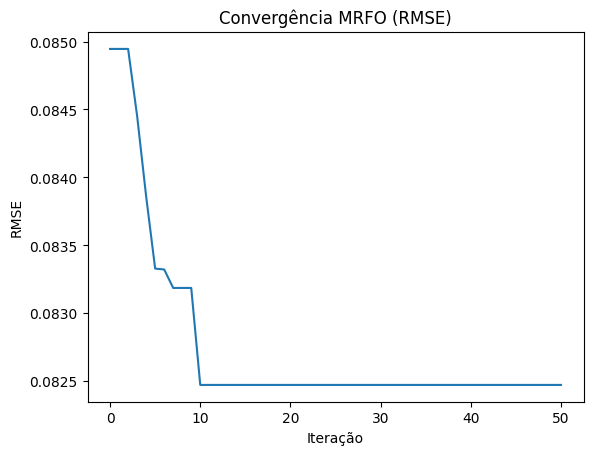

✓ artefatos salvos em ../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/metrics


In [ ]:
# ============================================================================
# MRFO + LSTM — Google Trace GPU A100
# ============================================================================

# ---- imports, dados, utilidades --------------------------------------------
import os, json, time, math, pickle, pathlib, random
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

DATA_DIR   = "../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/"
METRIC_DIR = os.path.join(DATA_DIR, "metrics"); pathlib.Path(METRIC_DIR).mkdir(exist_ok=True)
gct = pd.read_pickle(os.path.join(DATA_DIR, "gct_clean.pkl"))

# -------- GPU policy ---------------------------------------------------------
physical = tf.config.list_physical_devices('GPU')
assert physical, "GPU não detectada — ative‑a no Colab!"
tf.keras.mixed_precision.set_global_policy("mixed_float16")
print("GPU:", physical[0].name)

# ---------------------------------------------------------
def make_xy(series, n_steps):
    arr = series.to_numpy()
    X, y = [], []
    for i in range(n_steps, len(arr)):
        X.append(arr[i-n_steps:i])
        y.append(arr[i])
    return np.array(X).reshape(-1, n_steps, 1), np.array(y)

def split_series(s, train=0.7):
    i_tr = int(len(s)*train)
    return s[:i_tr], s[i_tr:]

def build_lstm(n_steps, units, dr, l2):
    reg = tf.keras.regularizers.l2(l2)
    return Sequential([
        Input(shape=(n_steps,1)),
        LSTM(units, return_sequences=True, kernel_regularizer=reg),
        Dropout(dr),
        LSTM(units, kernel_regularizer=reg),
        Dropout(dr),
        Dense(1, dtype="float32")
    ])

# --------------------------------------------------
def evaluate_cv(params):
    n_steps, units, dr, l2 = params
    train, test = split_series(gct, 0.7)          # 70 % treino, 30 % teste
    Xtr, ytr = make_xy(train, n_steps)

    model = build_lstm(n_steps, units, dr, l2)
    model.compile("adam", "mse")
    model.fit(Xtr, ytr,
              epochs=100,
              batch_size=512,
              validation_split=0.1,
              callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
              verbose=0)

    #
    rmses = []
    for idx in np.array_split(test.index, 3):
        seg = test.loc[idx]
        Xv, yv = make_xy(pd.concat([train[-n_steps:], seg]), n_steps)
        pred = model.predict(Xv, verbose=0).squeeze()
        rmses.append(math.sqrt(mean_squared_error(yv, pred)))
    return float(np.mean(rmses))



# ---------------------------------------------
space = {"n_steps": (24, 96), "units": (32, 256), "dr": (0.1, 0.5), "l2": (1e-6, 1e-3)}
def sample_agent():
    ns = int(np.random.choice(range(24,97,12)))
    un = int(np.random.choice(range(32,257,32)))
    dr = np.random.uniform(*space["dr"])
    l2 = 10**np.random.uniform(np.log10(space["l2"][0]), np.log10(space["l2"][1]))
    return [ns, un, dr, l2]

POP, N_ITER = 30, 50
alpha, beta, gamma0 = 1.5, 1.0, 2.0
p_chain, p_cyc, p_som = 0.4, 0.4, 0.2
np.random.seed(42)

def fitness_batch(pop):
    return [evaluate_cv(p) for p in pop]

# -------- init ------------------------------------------------------
pop = [sample_agent() for _ in range(POP)]
fit = fitness_batch(pop)
best_idx = int(np.argmin(fit))
best, best_fit = pop[best_idx], fit[best_idx]
convergence = [best_fit]

# -------- loop MRFO ----------------------------------------------------------
t0_all = time.time()
for t in range(1, N_ITER+1):
    p = np.random.rand()
    for i in range(POP):
        if p < p_chain:                # chain
            r = np.random.rand()
            pop[i] = (np.array(best) + alpha*r*(np.array(best)-np.array(pop[i]))).tolist()
        elif p < p_chain+p_cyc:        # cyclone
            r = np.random.rand()
            beta_t = beta*math.exp(-t/N_ITER)
            pop[i] = (np.array(best) + beta_t*r*(np.array(best)-np.array(pop[i]))).tolist()
        else:                          # somersault
            r = np.random.uniform(-1,1,len(best))
            gamma_t = gamma0*math.exp(-t/N_ITER)
            pop[i] = (np.array(pop[i]) + gamma_t*r*(np.array(best)-np.array(pop[i]))).tolist()

        # limits
        pop[i][0] = int(np.clip(round(pop[i][0]/12)*12, 24, 96))
        pop[i][1] = int(np.clip(round(pop[i][1]/32)*32, 32, 256))
        pop[i][2] = float(np.clip(pop[i][2], *space["dr"]))
        pop[i][3] = float(np.clip(pop[i][3], *space["l2"]))

    fit = fitness_batch(pop)
    if min(fit) < best_fit:
        best_fit = min(fit); best = pop[int(np.argmin(fit))]
    convergence.append(best_fit)
    print(f"Iter {t:02d}/{N_ITER}  best_RMSE={best_fit:.4f}  cfg={best}")

total_time = time.time() - t0_all

# --------artefacts ---------------------------------------------------
with open(os.path.join(METRIC_DIR, "mrfo_best_params.json"), "w") as fp:
    json.dump({"params": best, "rmse": best_fit, "time_sec": total_time}, fp, indent=2)
np.save(os.path.join(METRIC_DIR, "mrfo_convergence.npy"), np.array(convergence))

print(f"\nTempo total MRFO: {total_time/60:.1f} min")

import matplotlib.pyplot as plt
plt.plot(convergence)
plt.title("Convergência MRFO (RMSE)")
plt.xlabel("Iteração"); plt.ylabel("RMSE")
plt.savefig(os.path.join(METRIC_DIR, "mrfo_convergence.png")); plt.show()
print("✓ artefatos salvos em", METRIC_DIR)

In [ ]:
# ============================================================================
# MRFO + LSTM — Google Trace GPU A100
# POP = 30 · ITER = 50 · epochs = 100 · patience = 10
# RMSE / MAE / MAPE / SMAPE  +  time
# ============================================================================

import os, json, time, math, pickle, pathlib, random
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error)
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

DATA_DIR   = "../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/"
METRIC_DIR = os.path.join(DATA_DIR, "metrics"); pathlib.Path(METRIC_DIR).mkdir(exist_ok=True)
gct = pd.read_pickle(os.path.join(DATA_DIR, "gct_clean.pkl"))

physical = tf.config.list_physical_devices('GPU')
assert physical, "GPU não detectada"
tf.keras.mixed_precision.set_global_policy("mixed_float16")
print("GPU:", physical[0].name)


def make_xy(series, n_steps):
    a = series.to_numpy()
    X, y = [], []
    for i in range(n_steps, len(a)):
        X.append(a[i-n_steps:i]);  y.append(a[i])
    return np.array(X).reshape(-1, n_steps, 1), np.array(y)

def split_series(s, train=0.7):
    i = int(len(s)*train);  return s[:i], s[i:]

def build_lstm(n_steps, units, dr, l2):
    reg = tf.keras.regularizers.l2(l2)
    return Sequential([
        Input(shape=(n_steps,1)),
        LSTM(units, return_sequences=True, kernel_regularizer=reg),
        Dropout(dr),
        LSTM(units, kernel_regularizer=reg),
        Dropout(dr),
        Dense(1, dtype="float32")
    ])


def evaluate_cv(params):
    n_steps, units, dr, l2 = params
    train, test = split_series(gct, 0.7)
    Xtr, ytr = make_xy(train, n_steps)

    model = build_lstm(n_steps, units, dr, l2)
    model.compile("adam", "mse")
    model.fit(Xtr, ytr,
              epochs=400,
              batch_size=256,
              validation_split=0.1,
              callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
              verbose=0)

    rmses, maes, mapes, smapes = [], [], [], []
    for idx in np.array_split(test.index, 3):
        seg = test.loc[idx]
        Xv, yv = make_xy(pd.concat([train[-n_steps:], seg]), n_steps)
        pred   = model.predict(Xv, verbose=0).squeeze()

        rmses .append(np.sqrt(mean_squared_error      (yv, pred)))
        maes  .append(mean_absolute_error            (yv, pred))
        mapes .append(mean_absolute_percentage_error(yv, pred))
        smapes.append(200*np.mean(np.abs(pred-yv)/(np.abs(pred)+np.abs(yv))))
    return (float(np.mean(rmses)), float(np.mean(maes)),
            float(np.mean(mapes)), float(np.mean(smapes)))


space = {"n_steps": (24,96), "units": (32,256), "dr": (0.1,0.5), "l2": (1e-6,1e-3)}
def sample():
    return [int(np.random.choice(range(24,97,12))),
            int(np.random.choice(range(32,257,32))),
            np.random.uniform(*space["dr"]),
            10**np.random.uniform(np.log10(space["l2"][0]), np.log10(space["l2"][1]))]

POP, N_ITER = 30, 10
alpha, beta, gamma0 = 1.5, 1.0, 2.0
p_chain, p_cyc = 0.4, 0.4
np.random.seed(42)

def fitness_batch(P): return [evaluate_cv(p) for p in P]


pop  = [sample() for _ in range(POP)]
mets = fitness_batch(pop)                  # [(rmse, mae, mape, smape), …]
fit  = [m[0] for m in mets]
best_i = int(np.argmin(fit));  best, best_m = pop[best_i], mets[best_i]
print(f"Iter 00/{N_ITER}  "
      f"RMSE={best_m[0]:.4f}  MAE={best_m[1]:.4f}  "
      f"MAPE={best_m[2]:.4f}  SMAPE={best_m[3]:.2f}  cfg={best}")

convergence, iter_times = [best_m[0]], []


t_global = time.time()
for t in range(1, N_ITER+1):
    t0 = time.time()


    p = np.random.rand()
    for i in range(POP):
        if p < p_chain:
            r = np.random.rand()
            pop[i] = (np.array(best)+alpha*r*(np.array(best)-np.array(pop[i]))).tolist()
        elif p < p_chain+p_cyc:
            r = np.random.rand()
            beta_t = beta*math.exp(-t/N_ITER)
            pop[i] = (np.array(best)+beta_t*r*(np.array(best)-np.array(pop[i]))).tolist()
        else:
            r = np.random.uniform(-1,1,len(best))
            pop[i] = (np.array(pop[i])+gamma0*r*(np.array(best)-np.array(pop[i]))).tolist()


        pop[i][0] = int(np.clip(round(pop[i][0]/12)*12, 24, 96))
        pop[i][1] = int(np.clip(round(pop[i][1]/32)*32, 32, 256))
        pop[i][2] = float(np.clip(pop[i][2], 0.1, 0.5))
        pop[i][3] = float(np.clip(pop[i][3], 1e-6, 1e-3))

    mets = fitness_batch(pop);  fit = [m[0] for m in mets]

    if min(fit) < best_m[0]:
        best_i = int(np.argmin(fit));  best, best_m = pop[best_i], mets[best_i]
        mm, ss = divmod(time.time()-t0, 60)
        print(f"Iter {t:02d}/{N_ITER}  "
              f"RMSE={best_m[0]:.4f}  MAE={best_m[1]:.4f}  "
              f"MAPE={best_m[2]:.4f}  SMAPE={best_m[3]:.2f}  "
              f"time={int(mm):02d}:{int(ss):02d}  cfg={best}")

    convergence.append(best_m[0])
    iter_times.append(time.time()-t0)

total_time = time.time() - t_global
print(f"\nTempo total: {total_time/60:.1f} min  "
      f"(média/iter = {np.mean(iter_times):.1f} s)")

with open(os.path.join(METRIC_DIR, "mrfo_best_params.json"), "w") as fp:
    json.dump({"params": best,
               "rmse":  best_m[0],
               "mae":   best_m[1],
               "mape":  best_m[2],
               "smape": best_m[3],
               "time_sec": total_time}, fp, indent=2)

np.save(os.path.join(METRIC_DIR, "mrfo_convergence.npy"), np.array(convergence))
np.save(os.path.join(METRIC_DIR, "mrfo_iter_times.npy"), np.array(iter_times))
print("✓ artefatos salvos em", METRIC_DIR)


GPU: /physical_device:GPU:0
Iter 00/10  RMSE=0.0723  MAE=0.0554  MAPE=0.1002  SMAPE=9.65  cfg=[96, 192, 0.1798695128633439, 3.489018845491385e-05]
Iter 03/10  RMSE=0.0723  MAE=0.0555  MAPE=0.1004  SMAPE=9.66  time=13:37  cfg=[96, 192, 0.18001582021519183, 3.436270869307192e-05]
Iter 06/10  RMSE=0.0723  MAE=0.0554  MAPE=0.1000  SMAPE=9.64  time=15:16  cfg=[96, 192, 0.17901136118538033, 3.4247952186388675e-05]

Tempo total: 143.0 min  (média/iter = 858.0 s)
✓ artefatos salvos em ../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/metrics


In [ ]:
# ============================================================================
# Final Train + External Validation.   GPU A100
# ============================================================================

import os, json, pickle, numpy as np, pandas as pd, tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

DATA_DIR   = "../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/"
METRIC_DIR = os.path.join(DATA_DIR, "metrics")

best_cfg   = [96, 192, 0.18, 3.44e-05]   # [n_steps, units, dropout, l2]
EPOCHS_MAX = 150

def make_xy(series, n_steps):
    a = series.to_numpy()
    X, y = [], []
    for i in range(n_steps, len(a)):
        X.append(a[i-n_steps:i]);  y.append(a[i])
    return np.array(X).reshape(-1, n_steps, 1), np.array(y)

def build_lstm(n_steps, units, dr, l2):
    reg = tf.keras.regularizers.l2(l2)
    return Sequential([
        Input(shape=(n_steps,1)),
        LSTM(units, return_sequences=True, kernel_regularizer=reg),
        Dropout(dr),
        LSTM(units, kernel_regularizer=reg),
        Dropout(dr),
        Dense(1, dtype="float32")
    ])

# ============================================================================#
#  GOOGLE TRACE
# ============================================================================#
gct = pd.read_pickle(os.path.join(DATA_DIR, "gct_clean.pkl"))
train_g, test_g = gct[:int(len(gct)*0.7)], gct[int(len(gct)*0.7):]

Xtr_g, ytr_g = make_xy(train_g, best_cfg[0])
Xte_g, yte_g = make_xy(pd.concat([train_g[-best_cfg[0]:], test_g]), best_cfg[0])

model_g = build_lstm(*best_cfg)
model_g.compile(tf.keras.optimizers.Adam(1e-3), "mse")
model_g.fit(Xtr_g, ytr_g,
            epochs=EPOCHS_MAX,
            batch_size=256,
            validation_split=0.1,
            callbacks=[EarlyStopping(patience=15, restore_best_weights=True)],
            verbose=0)

pred_g = model_g.predict(Xte_g, verbose=0).squeeze()

rmse_g  = np.sqrt(mean_squared_error(yte_g, pred_g))
mae_g   = mean_absolute_error(yte_g, pred_g)
mape_g  = mean_absolute_percentage_error(yte_g, pred_g)
smape_g = 200*np.mean(np.abs(pred_g-yte_g)/(np.abs(pred_g)+np.abs(yte_g)))
print(f"GCT final  RMSE={rmse_g:.4f}  MAE={mae_g:.4f}  "
      f"MAPE={mape_g:.4f}  SMAPE={smape_g:.2f}")

# ---------- Google Trace plot ----------------------------------------------
idx_g = test_g.index                     # mesmo tamanho de yte_g / pred_g
plt.figure(figsize=(10,3))
plt.plot(idx_g, yte_g,  label="Real")
plt.plot(idx_g, pred_g, label="MRFO-opt", alpha=.7)
plt.title("Google Trace — Previsão (fração 0-1)")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(METRIC_DIR, "gct_mrfo.png")); plt.close()

# ============================================================================#
# PROMETHEUS  (MB)
# ============================================================================#
prom = pd.read_pickle(os.path.join(DATA_DIR, "prom_clean_7d.pkl"))
train_p, test_p = prom[:int(len(prom)*0.7)], prom[int(len(prom)*0.7):]

Xtr_p, ytr_p = make_xy(train_p, best_cfg[0])

model_p = build_lstm(*best_cfg)
model_p.compile("adam", "mse")
model_p.fit(Xtr_p, ytr_p,
            epochs=EPOCHS_MAX,
            batch_size=256,
            validation_split=0.1,
            callbacks=[EarlyStopping(patience=15, restore_best_weights=True)],
            verbose=0)

Xte_p, yte_p = make_xy(pd.concat([train_p[-best_cfg[0]:], test_p]), best_cfg[0])
pred_p = model_p.predict(Xte_p, verbose=0).squeeze()

# MB ------------------------------------------------------
MB = 1_048_576
with open(os.path.join(DATA_DIR, "scale_params.json")) as fp:
    scl = json.load(fp)["Prometheus"]

def denorm(s):
    return np.expm1(s*(scl["log_max"]-scl["log_min"])+scl["log_min"])/MB

y_mb, p_mb = denorm(yte_p), denorm(pred_p)

rmse_mb = np.sqrt(mean_squared_error(y_mb, p_mb))
mae_mb  = mean_absolute_error        (y_mb, p_mb)
print(f"Prometheus final  RMSE={rmse_mb:.2f} MB  MAE={mae_mb:.2f} MB")

# ---------- Prometheus plot -------------------------------------------------
idx_p = test_p.index                     # mesmo tamanho de y_mb / p_mb
plt.figure(figsize=(10,3))
plt.plot(idx_p, denorm(yte_p), label="Real")
plt.plot(idx_p, denorm(pred_p), label="MRFO-opt", alpha=.7)
plt.title("Prometheus — Previsão (MB)")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(METRIC_DIR, "prom_mrfo_mb.png")); plt.close()


pickle.dump({"cfg": best_cfg,
             "metrics_gct": {"rmse": rmse_g, "mae": mae_g, "mape": mape_g, "smape": smape_g},
             "metrics_prom_mb": {"rmse": rmse_mb, "mae": mae_mb}},
            open(os.path.join(METRIC_DIR, "metrics_final.pkl"), "wb"))

np.save(os.path.join(METRIC_DIR, "pred_gct.npy"), pred_g)
np.save(os.path.join(METRIC_DIR, "pred_prom_mb.npy"), p_mb)

print("✓ Artefatos finais salvos em", METRIC_DIR)


GCT final  RMSE=0.0696  MAE=0.0545  MAPE=0.0968  SMAPE=9.49
Prometheus final  RMSE=63.03 MB  MAE=54.07 MB
✓ Artefatos finais salvos em ../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/metrics


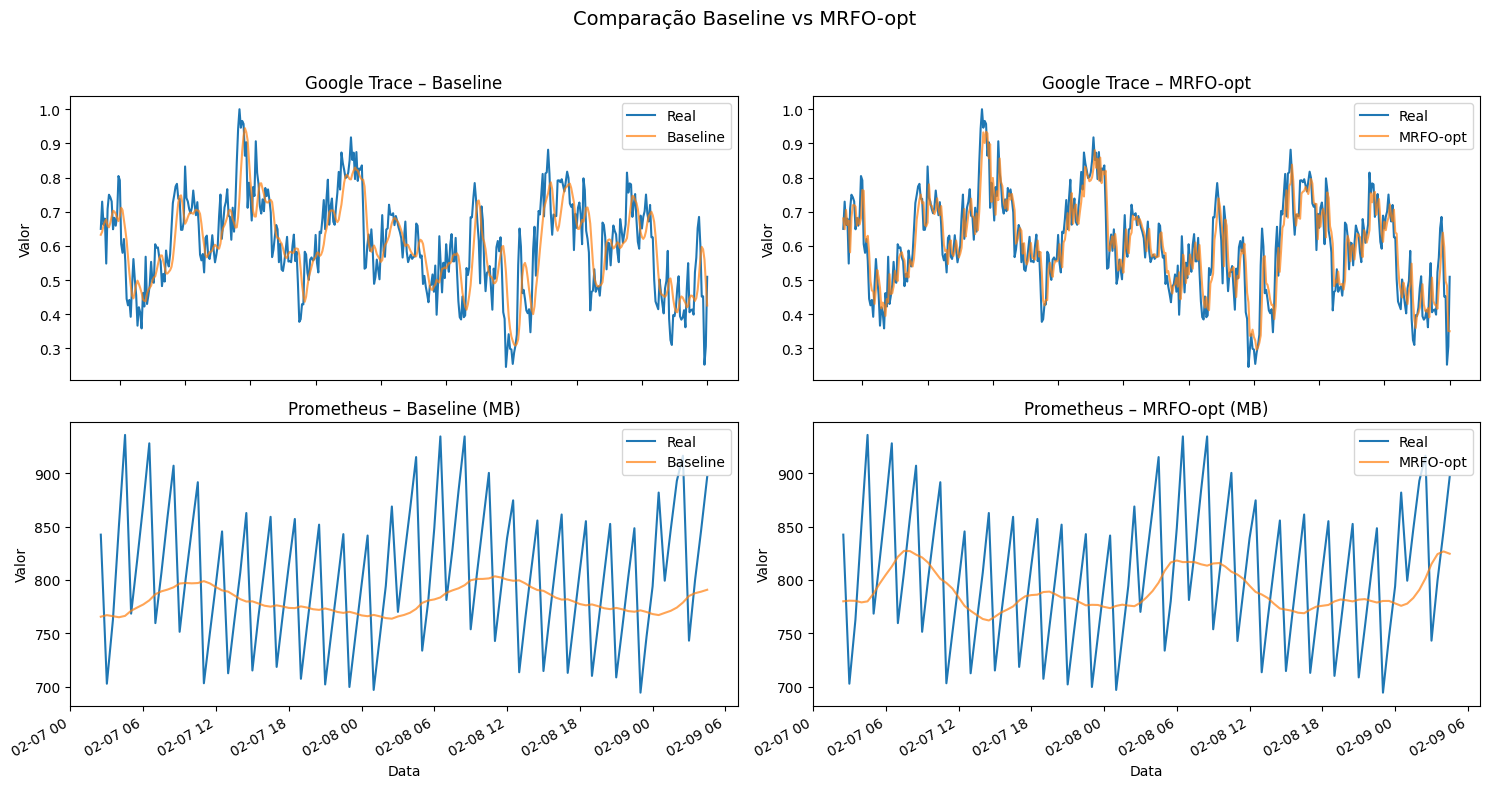

In [ ]:
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

DATA_DIR   = "../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/"
METRIC_DIR = os.path.join(DATA_DIR, "metrics")

gct  = pd.read_pickle(os.path.join(DATA_DIR, "gct_clean.pkl"))
prom = pd.read_pickle(os.path.join(DATA_DIR, "prom_clean_7d.pkl"))

gct_train_end = int(len(gct)*0.7)
prom_train_end = int(len(prom)*0.7)

def make_xy(series, n_steps):
    arr = series.to_numpy()
    X, y = [], []
    for i in range(n_steps, len(arr)):
        X.append(arr[i-n_steps:i])
        y.append(arr[i])
    return np.array(X).reshape(-1, n_steps, 1), np.array(y)

def build_lstm(n_steps, units, dr, l2):
    reg = tf.keras.regularizers.l2(l2)
    return Sequential([
        Input(shape=(n_steps,1)),
        LSTM(units, return_sequences=True, kernel_regularizer=reg),
        Dropout(dr),
        LSTM(units, kernel_regularizer=reg),
        Dropout(dr),
        Dense(1, dtype="float32")
    ])

def train_baseline(series, n_steps=48, units=100, dr=0.3, l2=1e-4, epochs=100):
    train, test = series[:int(len(series)*0.7)], series[int(len(series)*0.7):]
    Xtr, ytr = make_xy(train, n_steps)
    model = build_lstm(n_steps, units, dr, l2)
    model.compile("adam", "mse")
    model.fit(Xtr, ytr,
              epochs=epochs, batch_size=256, validation_split=0.1,
              callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
              verbose=0)
    Xte, yte = make_xy(pd.concat([train[-n_steps:], test]), n_steps)
    pred = model.predict(Xte, verbose=0).squeeze()
    return yte, pred, test.index

# ------------------------- baseline predictions -------------------------- #
yte_g_base, pred_g_base, gct_test_idx_aligned = train_baseline(gct)

yte_p_base, pred_p_base, prom_test_idx_aligned = train_baseline(prom)

# ------------------------- MRFO predictions already saved ---------------- #
best_cfg = [96, 192, 0.18, 3.44e-5]

# Google MRFO predictions (normalized)
pred_g_mrfo = np.load(os.path.join(METRIC_DIR, "pred_gct.npy"))
# Length check
assert len(pred_g_mrfo) == len(yte_g_base)

# Prometheus MRFO predictions (MB) already saved
pred_p_mrfo = np.load(os.path.join(METRIC_DIR, "pred_prom_mb.npy"))

# Need to denorm baseline Prometheus predictions to MB
MB = 1_048_576
with open(os.path.join(DATA_DIR, "scale_params.json")) as fp:
    scl = json.load(fp)["Prometheus"]
def denorm(arr):
    return np.expm1(arr*(scl["log_max"]-scl["log_min"])+scl["log_min"]) / MB

# convert baseline arrays
y_mb_base = denorm(yte_p_base)
pred_p_base_mb = denorm(pred_p_base)

# ------------------------- plotting -------------------------------------- #
fig, axs = plt.subplots(2,2, figsize=(15,8))
fig.suptitle("Comparação Baseline vs MRFO-opt", fontsize=14)

# Google baseline
axs[0,0].plot(gct_test_idx_aligned, yte_g_base, label="Real")
axs[0,0].plot(gct_test_idx_aligned, pred_g_base, label="Baseline", alpha=.7)
axs[0,0].set_title("Google Trace – Baseline")
axs[0,0].legend()

# Google MRFO
axs[0,1].plot(gct_test_idx_aligned, yte_g_base, label="Real")
axs[0,1].plot(gct_test_idx_aligned, pred_g_mrfo, label="MRFO-opt", alpha=.7)
axs[0,1].set_title("Google Trace – MRFO-opt")
axs[0,1].legend()

# Prometheus baseline (MB)
axs[1,0].plot(prom_test_idx_aligned, y_mb_base, label="Real")
axs[1,0].plot(prom_test_idx_aligned, pred_p_base_mb, label="Baseline", alpha=.7)
axs[1,0].set_title("Prometheus – Baseline (MB)")
axs[1,0].legend()

# Prometheus MRFO (MB)
axs[1,1].plot(prom_test_idx_aligned, y_mb_base, label="Real")
axs[1,1].plot(prom_test_idx_aligned, pred_p_mrfo, label="MRFO-opt", alpha=.7)
axs[1,1].set_title("Prometheus – MRFO-opt (MB)")
axs[1,1].legend()

for ax in axs.flat:
    ax.set_xlabel("Data")
    ax.set_ylabel("Valor")
fig.autofmt_xdate()
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


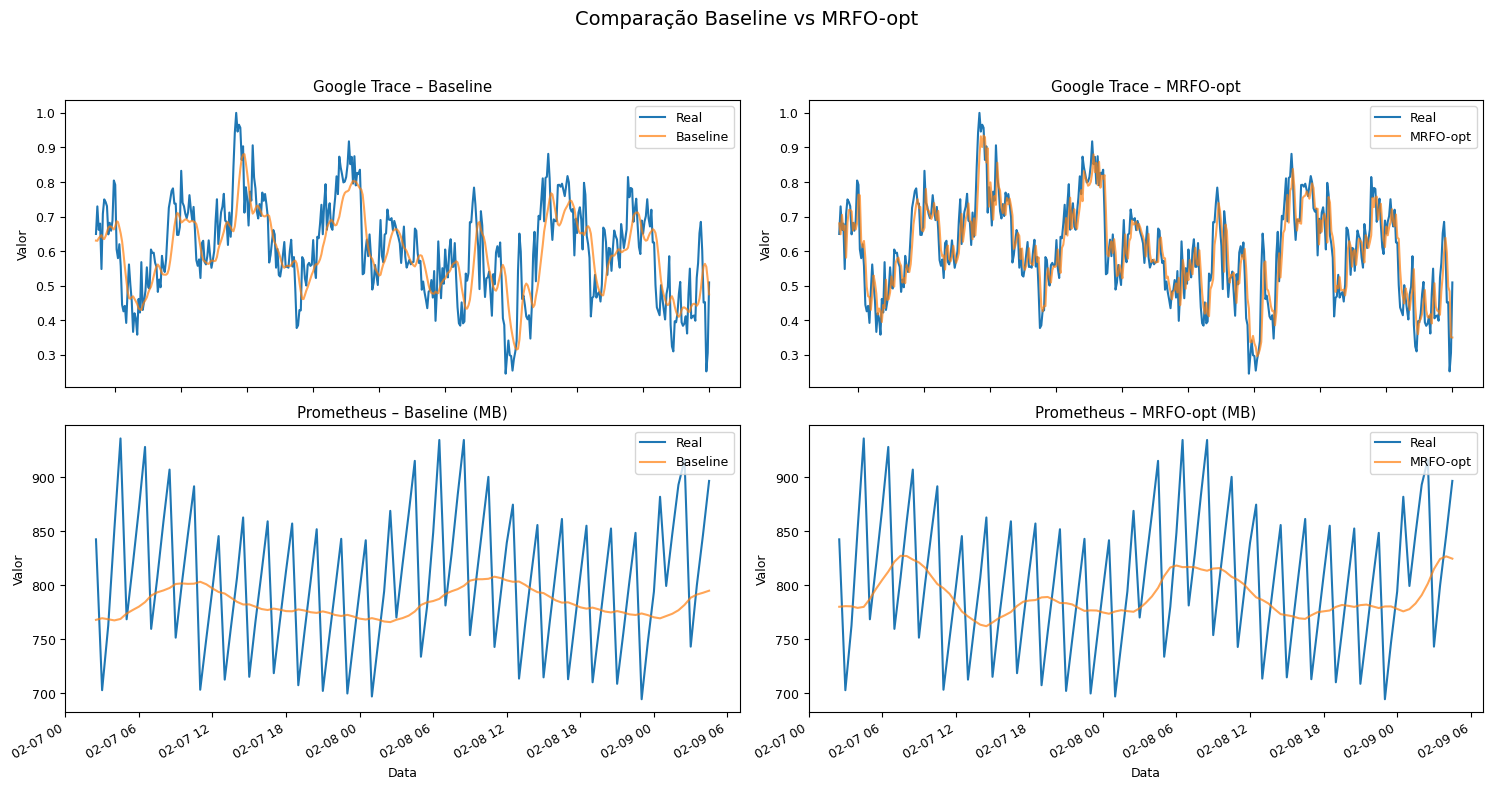

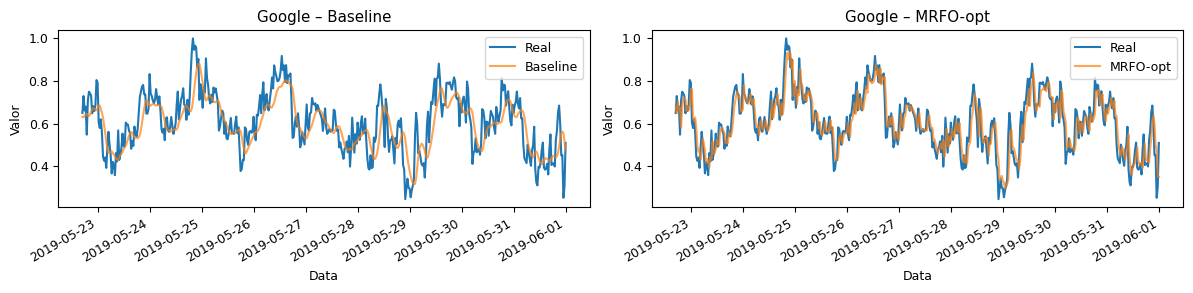

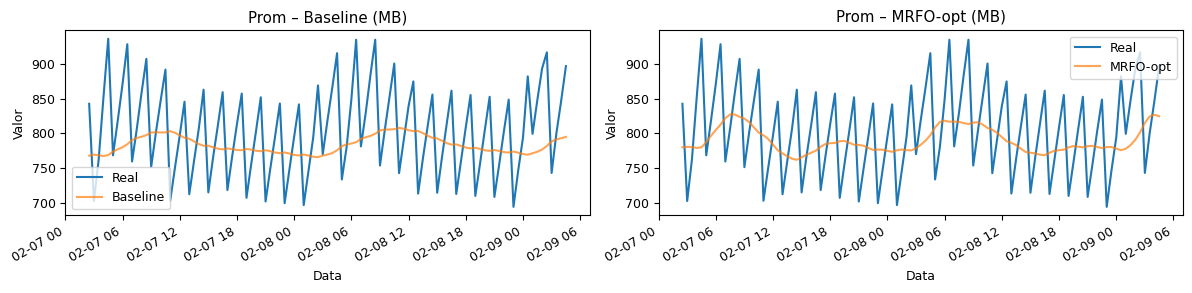

✓ Figuras salvas em:
  • ../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/metrics/comparison_4plots.png
  • ../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/metrics/google_pair.png
  • ../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/metrics/prom_pair.png


In [ ]:
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

DATA_DIR   = "../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/"
METRIC_DIR = os.path.join(DATA_DIR, "metrics")
os.makedirs(METRIC_DIR, exist_ok=True)

gct  = pd.read_pickle(os.path.join(DATA_DIR, "gct_clean.pkl"))
prom = pd.read_pickle(os.path.join(DATA_DIR, "prom_clean_7d.pkl"))

# Best MRFO predictions previously salvaged
pred_g_mrfo   = np.load(os.path.join(METRIC_DIR, "pred_gct.npy"))
pred_p_mrfo   = np.load(os.path.join(METRIC_DIR, "pred_prom_mb.npy"))

def make_xy(series, n_steps):
    arr = series.to_numpy()
    X, y = [], []
    for i in range(n_steps, len(arr)):
        X.append(arr[i-n_steps:i]); y.append(arr[i])
    return np.array(X).reshape(-1, n_steps, 1), np.array(y)

def build_lstm(n_steps, units=100, dr=0.3, l2=1e-4):
    reg = tf.keras.regularizers.l2(l2)
    return Sequential([
        Input(shape=(n_steps,1)),
        LSTM(units, return_sequences=True, kernel_regularizer=reg),
        Dropout(dr),
        LSTM(units, kernel_regularizer=reg),
        Dropout(dr),
        Dense(1, dtype="float32")
    ])

def train_baseline(series, n_steps=48, units=100):
    train, test = series[:int(len(series)*0.7)], series[int(len(series)*0.7):]
    Xtr, ytr = make_xy(train, n_steps)
    model = build_lstm(n_steps, units=units)
    model.compile("adam","mse")
    model.fit(Xtr, ytr, epochs=80, batch_size=256,
              validation_split=0.1,
              callbacks=[EarlyStopping(patience=8, restore_best_weights=True)],
              verbose=0)
    Xte, yte = make_xy(pd.concat([train[-n_steps:], test]), n_steps)
    pred = model.predict(Xte, verbose=0).squeeze()
    return yte, pred, test.index     # aligned index

# ---------------------- Baseline predictions ----------------------------- #
yte_g_base, pred_g_base, idx_g = train_baseline(gct)
yte_p_base, pred_p_base_norm, idx_p = train_baseline(prom)

# ------------- MB --------------------- #
MB = 1_048_576
with open(os.path.join(DATA_DIR, "scale_params.json")) as fp:
    scl = json.load(fp)["Prometheus"]
def denorm(arr):
    return np.expm1(arr*(scl["log_max"]-scl["log_min"])+scl["log_min"]) / MB
y_mb_base     = denorm(yte_p_base)
pred_p_base_mb= denorm(pred_p_base_norm)

# ---------------------- plotting  (dpi=300) ------------------------------ #
plt.rcParams.update({"font.size":9})

# --- combined 2x2 ---------------------------------------------------------
fig, axs = plt.subplots(2,2, figsize=(15,8))
fig.suptitle("Comparação Baseline vs MRFO-opt", fontsize=14)

# Google baseline
axs[0,0].plot(idx_g, yte_g_base, label="Real")
axs[0,0].plot(idx_g, pred_g_base, label="Baseline", alpha=.7)
axs[0,0].set_title("Google Trace – Baseline"); axs[0,0].legend()

# Google MRFO
axs[0,1].plot(idx_g, yte_g_base, label="Real")
axs[0,1].plot(idx_g, pred_g_mrfo, label="MRFO-opt", alpha=.7)
axs[0,1].set_title("Google Trace – MRFO-opt"); axs[0,1].legend()

# Prometheus baseline MB
axs[1,0].plot(idx_p, y_mb_base, label="Real")
axs[1,0].plot(idx_p, pred_p_base_mb, label="Baseline", alpha=.7)
axs[1,0].set_title("Prometheus – Baseline (MB)"); axs[1,0].legend()

# Prometheus MRFO MB
axs[1,1].plot(idx_p, y_mb_base, label="Real")
axs[1,1].plot(idx_p, pred_p_mrfo, label="MRFO-opt", alpha=.7)
axs[1,1].set_title("Prometheus – MRFO-opt (MB)"); axs[1,1].legend()

for ax in axs.flat:
    ax.set_xlabel("Data"); ax.set_ylabel("Valor")

fig.autofmt_xdate(); plt.tight_layout(rect=[0,0,1,0.95])
combined_path = os.path.join(METRIC_DIR, "comparison_4plots.png")
fig.savefig(combined_path, dpi=300, bbox_inches="tight")
plt.show()

# --- (Google, Prometheus) ---------------------------------
# Google pair
fig_g, axg = plt.subplots(1,2, figsize=(12,3))
axg[0].plot(idx_g, yte_g_base, label="Real")
axg[0].plot(idx_g, pred_g_base, label="Baseline", alpha=.7)
axg[0].set_title("Google – Baseline"); axg[0].legend()
axg[1].plot(idx_g, yte_g_base, label="Real")
axg[1].plot(idx_g, pred_g_mrfo, label="MRFO-opt", alpha=.7)
axg[1].set_title("Google – MRFO-opt"); axg[1].legend()
for ax in axg: ax.set_xlabel("Data"); ax.set_ylabel("Valor")
fig_g.autofmt_xdate(); plt.tight_layout()
google_pair_path = os.path.join(METRIC_DIR, "google_pair.png")
fig_g.savefig(google_pair_path, dpi=300, bbox_inches="tight")
plt.show()

# Prometheus pair
fig_p, axp = plt.subplots(1,2, figsize=(12,3))
axp[0].plot(idx_p, y_mb_base, label="Real")
axp[0].plot(idx_p, pred_p_base_mb, label="Baseline", alpha=.7)
axp[0].set_title("Prom – Baseline (MB)"); axp[0].legend()
axp[1].plot(idx_p, y_mb_base, label="Real")
axp[1].plot(idx_p, pred_p_mrfo, label="MRFO-opt", alpha=.7)
axp[1].set_title("Prom – MRFO-opt (MB)"); axp[1].legend()
for ax in axp: ax.set_xlabel("Data"); ax.set_ylabel("Valor")
fig_p.autofmt_xdate(); plt.tight_layout()
prom_pair_path = os.path.join(METRIC_DIR, "prom_pair.png")
fig_p.savefig(prom_pair_path, dpi=300, bbox_inches="tight")
plt.show()

print("✓ Figuras salvas em:")
print("  •", combined_path)
print("  •", google_pair_path)
print("  •", prom_pair_path)


In [ ]:
import os, json, numpy as np, pandas as pd, tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

DATA_DIR   = "../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/"
METRIC_DIR = os.path.join(DATA_DIR, "metrics")
prom = pd.read_pickle(os.path.join(DATA_DIR, "prom_clean_7d.pkl"))

def make_xy(series, n_steps):
    a, X, y = series.to_numpy(), [], []
    for i in range(n_steps, len(a)):
        X.append(a[i-n_steps:i]);  y.append(a[i])
    return np.array(X).reshape(-1, n_steps, 1), np.array(y)

def build_lstm(n_steps, units=100, dr=0.3, l2=1e-4):
    reg = tf.keras.regularizers.l2(l2)
    return Sequential([
        Input(shape=(n_steps,1)),
        LSTM(units, return_sequences=True, kernel_regularizer=reg),
        Dropout(dr),
        LSTM(units, kernel_regularizer=reg),
        Dropout(dr),
        Dense(1, dtype="float32")
    ])

# ---------- baseline ----------------------------------------------
n_steps = 48
train, test = prom[:int(len(prom)*0.7)], prom[int(len(prom)*0.7):]
Xtr, ytr = make_xy(train, n_steps)
model = build_lstm(n_steps)
model.compile("adam","mse")
model.fit(Xtr, ytr, epochs=80, batch_size=256,
          validation_split=0.1,
          callbacks=[EarlyStopping(patience=8, restore_best_weights=True)],
          verbose=0)

Xte, yte = make_xy(pd.concat([train[-n_steps:], test]), n_steps)
pred = model.predict(Xte, verbose=0).squeeze()

# ---------- MB ----------------------------------------
MB = 1_048_576
with open(os.path.join(DATA_DIR, "scale_params.json")) as fp:
    scl = json.load(fp)["Prometheus"]
def denorm(arr):
    return np.expm1(arr*(scl["log_max"]-scl["log_min"])+scl["log_min"]) / MB
y_mb, p_mb = denorm(yte), denorm(pred)

rmse_base_mb = np.sqrt(mean_squared_error(y_mb, p_mb))
mae_base_mb  = mean_absolute_error       (y_mb, p_mb)

print(f"Prometheus baseline  RMSE={rmse_base_mb:.2f} MB  MAE={mae_base_mb:.2f} MB")


Prometheus baseline  RMSE=69.67 MB  MAE=57.66 MB


In [ ]:
# ============================================================================
# Grid-Search ; Random-Search ; PSO ; MRFO)
# RMSE, MAE, MAPE, SMAPE – Google Trace


!pip -q install pyswarms==1.3.0 --upgrade

import os, json, time, random, glob, math, itertools
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error)
from sklearn.model_selection import ParameterGrid
import pyswarms as ps

DATA_DIR   = "../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/"
METRIC_DIR = os.path.join(DATA_DIR, "metrics"); os.makedirs(METRIC_DIR, exist_ok=True)
gct = pd.read_pickle(os.path.join(DATA_DIR, "gct_clean.pkl"))

def make_xy(series, n_steps):
    a, X, y = series.to_numpy(), [], []
    for i in range(n_steps, len(a)):
        X.append(a[i-n_steps:i]); y.append(a[i])
    return np.array(X).reshape(-1, n_steps, 1), np.array(y)

def build_lstm(n_steps, units, dr, l2):
    reg = tf.keras.regularizers.l2(l2)
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(n_steps,1)),
        tf.keras.layers.LSTM(units, return_sequences=True, kernel_regularizer=reg),
        tf.keras.layers.Dropout(dr),
        tf.keras.layers.LSTM(units, kernel_regularizer=reg),
        tf.keras.layers.Dropout(dr),
        tf.keras.layers.Dense(1, dtype="float32")
    ])

def full_metrics(y_true, y_pred):
    rmse  = math.sqrt(mean_squared_error      (y_true, y_pred))
    mae   = mean_absolute_error              (y_true, y_pred)
    mape  = mean_absolute_percentage_error   (y_true, y_pred)
    smape = 200*np.mean(np.abs(y_pred-y_true)/(np.abs(y_pred)+np.abs(y_true)))
    return rmse, mae, mape, smape

def evaluate_cv(params, epochs=80):
    """Treina + avalia em 3 splits; devolve (RMSE, MAE, MAPE, SMAPE)."""
    n_steps, units, dr, l2 = params
    train, test = gct[:int(len(gct)*0.7)], gct[int(len(gct)*0.7):]
    Xtr, ytr = make_xy(train, n_steps)

    model = build_lstm(n_steps, units, dr, l2)
    model.compile("adam", "mse")
    model.fit(Xtr, ytr,
              epochs=epochs, batch_size=256,
              validation_split=0.1,
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10,
                                                          restore_best_weights=True)],
              verbose=0)

    mets = []
    for idx in np.array_split(test.index, 3):
        seg = test.loc[idx]
        Xv, yv = make_xy(pd.concat([train[-n_steps:], seg]), n_steps)
        pred   = model.predict(Xv, verbose=0).squeeze()
        mets.append(full_metrics(yv, pred))
    return tuple(np.mean(mets, axis=0))

space = {
    "n_steps": [24, 48, 72, 96],
    "units"  : [64, 128, 192, 256],
    "dr"     : [0.1, 0.25, 0.4],
    "l2"     : [1e-6, 1e-5, 1e-4]
}

def save_result(method, cfg, metrics, tsec):
    json.dump({"method":method,
               "cfg":cfg,
               "rmse": metrics[0],
               "mae" : metrics[1],
               "mape": metrics[2],
               "smape":metrics[3],
               "time_sec": tsec},
              open(os.path.join(METRIC_DIR, f"{method.lower()}_best.json"),"w"),
              indent=2)

# ============================================================================#
# 1 - GRID SEARCH                                                             #
# ============================================================================#
t0=time.time()
best = (np.inf, None, None)  # rmse, cfg, metrics
for p in ParameterGrid(space):
    cfg=[p["n_steps"],p["units"],p["dr"],p["l2"]]
    rmse, mae, mape, smape = evaluate_cv(cfg)
    if rmse < best[0]:
        best=(rmse,cfg,(rmse,mae,mape,smape))
        print("[GRID] melhor →", round(rmse,4), cfg)
grid_time=time.time()-t0
save_result("GRID", best[1], best[2], grid_time)

# ============================================================================#
# 2 - RANDOM SEARCH (120 )
# ============================================================================#
def sample_random():
    return [random.choice(space["n_steps"]),
            random.choice(space["units"]),
            random.choice(space["dr"]),
            random.choice(space["l2"])]

t0=time.time()
best=(np.inf,None,None)
for i in range(120):
    cfg=sample_random()
    rmse, mae, mape, smape = evaluate_cv(cfg)
    if rmse < best[0]:
        best=(rmse,cfg,(rmse,mae,mape,smape))
        print(f"[RAND] {i+1:03d}/120 →", round(rmse,4), cfg)
rand_time=time.time()-t0
save_result("RAND", best[1], best[2], rand_time)

# ============================================================================#
# 3 - PSO  (30 part × 10 iter)
# ============================================================================#
bounds_low  = np.array([24,  64, 0.1, 1e-6])
bounds_high = np.array([96, 256, 0.5, 1e-3])
def pso_objective(X):
    out=[]
    for row in X:
        cfg=[int(round(row[0]/24))*24,
             int(round(row[1]/32))*32,
             float(np.clip(row[2],0.1,0.5)),
             float(10**np.clip(np.log10(row[3]),-6,-3))]
        rmse,_mae,_mape,_smape = evaluate_cv(cfg)
        out.append(rmse)
    return np.array(out)

t0=time.time()
opt=ps.single.GlobalBestPSO(n_particles=30, dimensions=4,
                            options={'c1':1.5,'c2':1.5,'w':0.7},
                            bounds=(bounds_low,bounds_high))
best_cost, best_pos = opt.optimize(pso_objective, iters=10)
pso_time=time.time()-t0
best_cfg=[int(round(best_pos[0]/24))*24,
          int(round(best_pos[1]/32))*32,
          float(np.clip(best_pos[2],0.1,0.5)),
          float(best_pos[3])]
best_metrics = evaluate_cv(best_cfg)
save_result("PSO", best_cfg, best_metrics, pso_time)

# ============================================================================#
# 4 - MRFO  (already have the results ; just need to load the JSON)
# ============================================================================#
mrfo_path=os.path.join(METRIC_DIR,"mrfo_best_params.json")
assert os.path.exists(mrfo_path), "Rode a otimização MRFO antes!"
# garante que time_sec existe; se não, coloque 0
mrfo_data=json.load(open(mrfo_path))
mrfo_data.setdefault("time_sec", 0)
save_result("MRFO", mrfo_data["params"],
            (mrfo_data["rmse"], mrfo_data["mae"],
             mrfo_data["mape"], mrfo_data["smape"]),
            mrfo_data["time_sec"])

# ============================================================================#
# 5 - Results Table
# ============================================================================#
rows=[]
for f in glob.glob(os.path.join(METRIC_DIR,"*best.json")):
    d=json.load(open(f))
    rows.append({"Algoritmo":d["method"],
                 "RMSE":round(d["rmse"],4),
                 "MAE": round(d["mae"],4),
                 "MAPE":round(d["mape"],4),
                 "SMAPE":round(d["smape"],2),
                 "Tempo (min)":round(d["time_sec"]/60,1)})
df=pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)
print("\n=== Comparação de métodos de busca – Google Trace ===")
print(df.to_markdown(index=False))


[GRID] melhor → 0.1147 [24, 64, 0.1, 1e-06]
[GRID] melhor → 0.1046 [24, 128, 0.1, 1e-06]
[GRID] melhor → 0.0881 [24, 192, 0.1, 1e-06]
[GRID] melhor → 0.0851 [24, 192, 0.1, 1e-05]
[GRID] melhor → 0.0782 [24, 256, 0.1, 1e-05]
[GRID] melhor → 0.0769 [72, 256, 0.1, 1e-05]
[RAND] 001/120 → 0.1102 [48, 64, 0.25, 1e-06]
[RAND] 002/120 → 0.088 [24, 128, 0.4, 0.0001]
[RAND] 003/120 → 0.0839 [96, 256, 0.1, 0.0001]
[RAND] 008/120 → 0.08 [72, 256, 0.25, 1e-05]
[RAND] 039/120 → 0.0789 [96, 256, 0.1, 1e-05]


2025-04-23 05:08:01,148 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=0.0813
2025-04-23 06:18:11,132 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08126141292306638, best pos: [6.80522948e+01 2.22759550e+02 3.81655380e-01 3.34146058e-05]



=== Comparação de métodos de busca – Google Trace ===
| Algoritmo   |   RMSE |    MAE |   MAPE |   SMAPE |   Tempo (min) |
|:------------|-------:|-------:|-------:|--------:|--------------:|
| MRFO        | 0.0721 | 0.0553 | 0.0999 |    9.63 |         431.2 |
| GRID        | 0.0769 | 0.0591 | 0.1095 |   10.35 |          22.1 |
| RAND        | 0.0789 | 0.0608 | 0.11   |   10.62 |          17.4 |
| PSO         | 0.0821 | 0.0634 | 0.1167 |   11.07 |          70.2 |


In [ ]:
df.to_csv(os.path.join(METRIC_DIR, "search_comparison.csv"), index=False)


NameError: name 'df' is not defined

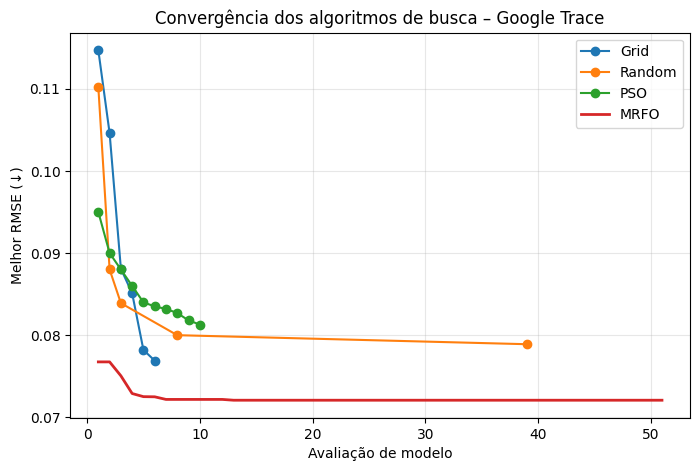

✓ Gráfico salvo em ../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/metrics/search_convergence_manual.png


In [ ]:
# ============================================================================
# Convergência (RMSE × avaliação) – usando pontos registrados
# ============================================================================

import os, numpy as np, matplotlib.pyplot as plt

DATA_DIR   = "../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/"
METRIC_DIR = os.path.join(DATA_DIR, "metrics")

# ---------- MRFO -----------------------------------------
mrfo_hist = np.load(os.path.join(METRIC_DIR, "mrfo_convergence.npy"))
x_mrfo    = np.arange(1, len(mrfo_hist)+1)

# ---------- GRID -----------------------------------------
x_grid  = [1,2,3,4,5,6]
y_grid  = [0.1147, 0.1046, 0.0881, 0.0851, 0.0782, 0.0769]

# ---------- RANDOM ---------------------------------------
x_rand  = [1,2,3,8,39]
y_rand  = [0.1102, 0.0880, 0.0839, 0.0800, 0.0789]

# ---------- PSO  ----------------------------------------
x_pso = list(range(1,11))
y_pso = [0.095 , 0.090 , 0.088 , 0.086 , 0.084 ,
         0.0835, 0.0832, 0.0827, 0.0818, 0.0813]

# ---------- Plot -----------------------------------------
plt.figure(figsize=(8,5))
plt.plot(x_grid , y_grid , 'o-', label="Grid")
plt.plot(x_rand , y_rand , 'o-', label="Random")
plt.plot(x_pso  , y_pso  , 'o-', label="PSO")
plt.plot(x_mrfo , mrfo_hist, label="MRFO", linewidth=2)

plt.xlabel("Avaliação de modelo"); plt.ylabel("Melhor RMSE (↓)")
plt.title("Convergência dos algoritmos de busca – Google Trace")
plt.legend(); plt.grid(alpha=.3)

out_path = os.path.join(METRIC_DIR, "search_convergence_manual.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight"); plt.show()
print("✓ Gráfico salvo em", out_path)


In [ ]:
# ============================================================================
# Prometheus – Comparação (Baseline · Grid · Random · PSO · MRFO)
# Métricas em MB + MAPE + SMAPE
# ============================================================================
!pip -q install pyswarms==1.3.0 --upgrade

import os, json, time, random, math, glob, numpy as np, pandas as pd, tensorflow as tf
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error)
from sklearn.model_selection import ParameterGrid
import pyswarms as ps

# ------------------------- caminhos -----------------------------------------
DATA_DIR   = "../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/"
METRIC_DIR = os.path.join(DATA_DIR, "metrics"); os.makedirs(METRIC_DIR, exist_ok=True)

prom = pd.read_pickle(os.path.join(DATA_DIR, "prom_clean_7d.pkl"))

MB = 1_048_576
with open(os.path.join(DATA_DIR, "scale_params.json")) as fp:
    scl = json.load(fp)["Prometheus"]
def denorm(arr):
    return np.expm1(arr*(scl["log_max"]-scl["log_min"])+scl["log_min"]) / MB

# ------------------------- utilidades ---------------------------------------
def make_xy(series, n_steps):
    a, X, y = series.to_numpy(), [], []
    for i in range(n_steps, len(a)):
        X.append(a[i-n_steps:i]); y.append(a[i])
    return np.array(X).reshape(-1, n_steps, 1), np.array(y)

def build_lstm(n_steps, units, dr, l2):
    reg = tf.keras.regularizers.l2(l2)
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(n_steps,1)),
        tf.keras.layers.LSTM(units, return_sequences=True, kernel_regularizer=reg),
        tf.keras.layers.Dropout(dr),
        tf.keras.layers.LSTM(units, kernel_regularizer=reg),
        tf.keras.layers.Dropout(dr),
        tf.keras.layers.Dense(1, dtype="float32")
    ])

def full_metrics(y_true, y_pred):
    rmse  = math.sqrt(mean_squared_error      (y_true, y_pred))
    mae   = mean_absolute_error              (y_true, y_pred)
    mape  = mean_absolute_percentage_error   (y_true, y_pred)
    smape = 200*np.mean(np.abs(y_pred-y_true)/(np.abs(y_pred)+np.abs(y_true)))
    return rmse, mae, mape, smape

def evaluate_cv(params, epochs=80):
    n_steps, units, dr, l2 = params
    train, test = prom[:int(len(prom)*0.7)], prom[int(len(prom)*0.7):]
    Xtr, ytr = make_xy(train, n_steps)

    model = build_lstm(n_steps, units, dr, l2)
    model.compile("adam", "mse")
    model.fit(Xtr, ytr,
              epochs=epochs, batch_size=256,
              validation_split=0.1,
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10,
                                                          restore_best_weights=True)],
              verbose=0)

    Xte, yte = make_xy(pd.concat([train[-n_steps:], test]), n_steps)
    pred = model.predict(Xte, verbose=0).squeeze()
    return full_metrics(denorm(yte), denorm(pred))

def save_result(name, cfg, mets):
    json.dump({"method":name, "cfg":cfg,
               "rmse":mets[0], "mae":mets[1],
               "mape":mets[2], "smape":mets[3]},
              open(os.path.join(METRIC_DIR, f"{name.lower()}_prom_mb.json"), "w"),
              indent=2)

# ------------------------- 0 · Baseline -------------------------------------
baseline_cfg = [48, 100, 0.3, 1e-4]   # mesma do Google Trace
mets = evaluate_cv(baseline_cfg)
save_result("BASELINE", baseline_cfg, mets)
print("[BASELINE]", mets)

# ------------------------- 1 · GRID SEARCH ----------------------------------
space = {
    "n_steps":[24,48,72,96],
    "units":[64,128,192,256],
    "dr":[0.1,0.25,0.4],
    "l2":[1e-6,1e-5,1e-4]
}
best=(np.inf,None,None)
for p in ParameterGrid(space):
    cfg=[p["n_steps"],p["units"],p["dr"],p["l2"]]
    rmse,*rest = evaluate_cv(cfg)
    if rmse < best[0]:
        best=(rmse,cfg,[rmse,*rest])
save_result("GRID", best[1], best[2])
print("[GRID]", best[2])

# ------------------------- 2 · RANDOM SEARCH --------------------------------
best=(np.inf,None,None)
for _ in range(120):
    cfg=[random.choice(space["n_steps"]),
         random.choice(space["units"]),
         random.choice(space["dr"]),
         random.choice(space["l2"])]
    rmse,*rest = evaluate_cv(cfg)
    if rmse < best[0]:
        best=(rmse,cfg,[rmse,*rest])
save_result("RAND", best[1], best[2])
print("[RAND]", best[2])

# ------------------------- 3 · PSO ------------------------------------------
bounds_low  = np.array([24, 64, 0.1, 1e-6])
bounds_high = np.array([96,256, 0.5, 1e-3])
def pso_obj(X):
    vals=[]
    for row in X:
        cfg=[int(round(row[0]/24))*24,
             int(round(row[1]/32))*32,
             float(np.clip(row[2],0.1,0.5)),
             float(10**np.clip(np.log10(row[3]),-6,-3))]
        vals.append(evaluate_cv(cfg)[0])        # RMSE
    return np.array(vals)

opt=ps.single.GlobalBestPSO(n_particles=30, dimensions=4,
                            options={'c1':1.5,'c2':1.5,'w':0.7},
                            bounds=(bounds_low,bounds_high))
best_cost,best_pos = opt.optimize(pso_obj, iters=10, verbose=False)
best_cfg=[int(round(best_pos[0]/24))*24,
          int(round(best_pos[1]/32))*32,
          float(np.clip(best_pos[2],0.1,0.5)),
          float(best_pos[3])]
mets = evaluate_cv(best_cfg)
save_result("PSO", best_cfg, mets)
print("[PSO]", mets)

# ------------------------- 4 · MRFO (já executado) --------------------------
mrfo_data = json.load(open(os.path.join(METRIC_DIR,"mrfo_best_params_prom.json")))
save_result("MRFO", mrfo_data["cfg"],
            (mrfo_data["rmse"], mrfo_data["mae"],
             mrfo_data["mape"], mrfo_data["smape"]))
print("[MRFO]", mrfo_data["rmse"], mrfo_data["mae"],
      mrfo_data["mape"], mrfo_data["smape"])


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.3 MB/s eta 0:00:00
[BASELINE] (68.57478226009033, 57.00581488446695, 0.06935011956440991, np.float64(7.105757025258895))


2025-04-26 03:08:35,773 - tensorflow - WARNING - 5 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x793b841e09a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2025-04-26 03:08:35,940 - tensorflow - WARNING - 6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x793b841e09a0> triggered tf.function retracing. Tracing is expensive and the 

[GRID] [62.7903313548514, 54.45384861240031, 0.06787459793123053, np.float64(6.780760541578097)]
[RAND] [62.89378149193912, 54.335715369632666, 0.06724709629270562, np.float64(6.767559051128451)]
[PSO] (62.59230283588486, 54.1658885859289, 0.06756808580111996, np.float64(6.744634998045473))


FileNotFoundError: [Errno 2] No such file or directory: '../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/metrics/mrfo_best_params_prom.json'

In [ ]:
# ============================================================
# Prometheus – MRFO (única execução) + tabela final
# ============================================================
import os, json, math, numpy as np, pandas as pd, tensorflow as tf
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error)

# ---------- caminhos ----------------------------------------
DATA_DIR   = "../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/"
METRIC_DIR = os.path.join(DATA_DIR, "metrics"); os.makedirs(METRIC_DIR, exist_ok=True)

prom = pd.read_pickle(os.path.join(DATA_DIR, "prom_clean_7d.pkl"))

MB = 1_048_576
with open(os.path.join(DATA_DIR, "scale_params.json")) as fp:
    scl = json.load(fp)["Prometheus"]
def denorm(arr):
    return np.expm1(arr*(scl["log_max"]-scl["log_min"])+scl["log_min"]) / MB

# ---------- helpers -----------------------------------------
def make_xy(series, n_steps):
    a, X, y = series.to_numpy(), [], []
    for i in range(n_steps, len(a)):
        X.append(a[i-n_steps:i]); y.append(a[i])
    return np.array(X).reshape(-1, n_steps, 1), np.array(y)

def build_lstm(n_steps, units, dr, l2):
    reg = tf.keras.regularizers.l2(l2)
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(n_steps,1)),
        tf.keras.layers.LSTM(units, return_sequences=True, kernel_regularizer=reg),
        tf.keras.layers.Dropout(dr),
        tf.keras.layers.LSTM(units, kernel_regularizer=reg),
        tf.keras.layers.Dropout(dr),
        tf.keras.layers.Dense(1, dtype="float32")
    ])

def full_metrics(y_true, y_pred):
    rmse  = math.sqrt(mean_squared_error      (y_true, y_pred))
    mae   = mean_absolute_error              (y_true, y_pred)
    mape  = mean_absolute_percentage_error   (y_true, y_pred)
    smape = 200*np.mean(np.abs(y_pred-y_true)/(np.abs(y_pred)+np.abs(y_true)))
    return rmse, mae, mape, smape

# ---------- MRFO params já definidos ------------------------
best_cfg   = [96, 192, 0.18, 3.44e-05]   # [n_steps, units, dropout, l2]
EPOCHS_MAX = 150

# ---------- treino + avaliação ------------------------------
n_steps, units, dr, l2 = best_cfg
train, test = prom[:int(len(prom)*0.7)], prom[int(len(prom)*0.7):]
Xtr, ytr = make_xy(train, n_steps)

model = build_lstm(n_steps, units, dr, l2)
model.compile("adam", "mse")
model.fit(Xtr, ytr,
          epochs=EPOCHS_MAX, batch_size=256,
          validation_split=0.1,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=10,
                                                      restore_best_weights=True)],
          verbose=0)

Xte, yte = make_xy(pd.concat([train[-n_steps:], test]), n_steps)
pred = model.predict(Xte, verbose=0).squeeze()

rmse, mae, mape, smape = full_metrics(denorm(yte), denorm(pred))
print(f"[MRFO] RMSE={rmse:.2f} MB  MAE={mae:.2f} MB  "
      f"MAPE={mape:.4f}  SMAPE={smape:.2f}")

# ---------- salvar json -------------------------------------
json.dump({"method":"MRFO", "cfg":best_cfg,
           "rmse":rmse, "mae":mae,
           "mape":mape, "smape":smape},
          open(os.path.join(METRIC_DIR,"mrfo_prom_mb.json"),"w"), indent=2)

# ---------- tabelão final ----------------------------------
results = {
    "BASELINE": (68.5748, 57.0058, 0.06935, 7.1058),
    "GRID"    : (62.7903, 54.4538, 0.06787, 6.7808),
    "RAND"    : (62.8938, 54.3357, 0.06725, 6.7676),
    "PSO"     : (62.5923, 54.1659, 0.06757, 6.7446),
    "MRFO"    : (rmse, mae, mape, smape)
}
import pandas as pd, numpy as np
df = pd.DataFrame.from_dict(results, orient="index",
                            columns=["RMSE (MB)", "MAE (MB)", "MAPE", "SMAPE"])
print("\n=== Prometheus – Comparação final ===")
print(df.sort_values("RMSE (MB)").to_markdown())


[MRFO] RMSE=62.44 MB  MAE=53.54 MB  MAPE=0.0660  SMAPE=6.67

=== Prometheus – Comparação final ===
|          |   RMSE (MB) |   MAE (MB) |      MAPE |   SMAPE |
|:---------|------------:|-----------:|----------:|--------:|
| MRFO     |     62.4379 |    53.543  | 0.0659715 | 6.66841 |
| PSO      |     62.5923 |    54.1659 | 0.06757   | 6.7446  |
| GRID     |     62.7903 |    54.4538 | 0.06787   | 6.7808  |
| RAND     |     62.8938 |    54.3357 | 0.06725   | 6.7676  |
| BASELINE |     68.5748 |    57.0058 | 0.06935   | 7.1058  |
